In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import sys, os
from utils.basic_utils import *
from utils.pricing import *
from utils.fundamental import *
from utils import ml_utils as mu

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

Loading utils/config.json


In [2]:
# environment variables
freq = '1d'
cuts = { '1d': [-1, -0.1, -.02, .02, .1, 1.] }
cut_range = cuts[freq]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

# pricing, refresh once
benchSL, sectorSL, riskSL, rateSL, bondSL, commSL, currSL = \
    config['benchmarks'], config['sectors'], config['risk'], config['rates'], \
    config['bonds'], config['commodities'], config['currencies']
symbols_list = benchSL + sectorSL + riskSL + rateSL + bondSL + commSL + currSL

keep_bench = excl(benchSL, ['^STOXX50E', '^AXJO'])
keep_fx = excl(currSL, ['HKD=X', 'MXN=X', 'AUDUSD=X', 'NZDUSD=X', 'TWD=X', 'CLP=X', 'KRW=X'])
keep_sect = excl(sectorSL, ['SPY', 'QQQ', 'DIA', 'IWM', 'XLC', 'XLRE'])
keep_bonds = ['LQD', 'HYG']

include = riskSL + keep_bench + keep_sect + rateSL + keep_fx + keep_bonds
invert = ['EURUSD=X', 'GBPUSD=X']
incl_price = riskSL

bench = '^GSPC'
y_col = 'fwdReturn'
pred_fwd_windows = [20, 60, 120]
rate_windows = [20, 60]
sec_windows, stds = [5, 20, 60], 1

In [45]:
# utility functions
def create_ds(px_close, context):
    print('create_ds')
    train_model = context['train_model']
    portion = context['portion']
    verbose = context['verbose']
    # average the return of the next periods
    # select only rows where Y variable is not null
    ds_idx = px_close.dropna(subset=[bench]).index

    df_large = pd.DataFrame()
    rate_ft_df = rate_feats(px_close[rateSL], rate_windows) # rate transforms
    df_large[rate_ft_df.columns] = rate_ft_df

    # price momentum transforms
    super_list = []
    for ticker in include:
        inv = ticker in invert
        incl_px = ticker in incl_price
        df = px_close[ticker]
        ft_df = px_mom_feats(df, ticker, stds, inv, incl_px, sec_windows)
        super_list.append(ft_df.drop_duplicates())
    df_large = pd.concat(super_list, axis=1).sort_index()
    df_large = df_large.loc[ds_idx, :] # drop NAs before discretizing

    if train_model:
        Y = px_fwd_rets(px_close.loc[ds_idx, bench], bench, pred_fwd_windows).mean(axis=1)
        df_large[y_col] = Y
        # reduce dataset?
        if portion < 100e-2: _, df_large = train_test_split(
            df_large, test_size=portion, random_state=42)
        if verbose:
            print('create_ds >> df_large.shape: ', df_large.shape)
            print('Y.shape: ', Y.shape)

    return ds_idx, df_large

def pre_process_ds(raw_df, context):

    print('pre_process_ds')
    fill_on, scaler_on = context['fill'], context['scale']

    scaler = StandardScaler()
    X_cols = excl(raw_df.columns, [y_col])

    raw_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    if scaler_on: raw_df[X_cols] = scaler.fit_transform(raw_df[X_cols])
    if fill_on: raw_df.loc[:, X_cols] = raw_df.fillna(method=fill_on)
        
    return raw_df

def train_ds(context):

    print('Benchmark: {}, Y: {}, Include: {}, invert: {}, include price: {}'.format(
    bench, y_col, include, invert, incl_price))

    context['train_model'] = True
    ml_path = context['ml_path']
    imputer_on = context['impute']    
    grid_search = context['grid_search']
    verbose = context['verbose']
    test_sz = context['test_size']
    ml_path = context['ml_path']
    train_cols = context['trained_cols']
    verbose = context['verbose']    

    # create and pre-process datasets
    _, df_large = create_ds(px_close, context)
#     pred_X, X_train, X_test, y_train, y_test = pre_process_ds(df_large, context)

    raw_df = pre_process_ds(df_large, context)

    # discretize forward returns into classes
    raw_df.dropna(subset=[y_col], inplace=True)
    raw_df.loc[:, y_col] = discret_rets(raw_df[y_col], cut_range, fwd_ret_labels)
    raw_df.dropna(subset=[y_col], inplace=True) # no nas in y_col
    print(sample_wgts(raw_df[y_col]))
    raw_df.loc[:, y_col] = raw_df[y_col].astype(str) # class as string

    imputer = SimpleImputer(
        missing_values=np.nan, strategy='median', copy=False)
    X_cols = excl(raw_df.columns, [y_col])
    
    if imputer_on: raw_df.loc[:, X_cols] = imputer.fit_transform(raw_df[X_cols])
    else: raw_df.dropna(inplace=True)

    X, y = raw_df.drop(columns=y_col), raw_df[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_sz, random_state=42)
    np.save(ml_path + train_cols, X_train.columns) # save feature order

    # RandomForestClassifier
    features = X_train.shape[1]
    best_params = { # best from GridSearch
        'n_estimators': 50,
        'max_features': features // 4,
        'max_depth': 30,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'random_state': 2,
        'n_jobs': -1}
    if grid_search:
        print('GridSearchCV for RandomForestClassifier')
        param_grid = {
            'n_estimators': [50],
            'max_features': [features // x for x in range(1,10,1)],
            'max_depth': 30,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'random_state': np.arange(0, 5, 1),
        }
        clf = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid, n_jobs=-1,
                           cv=5, iid=True, verbose=verbose)
        clf.fit(X_train, y_train)
        if verbose: print_cv_results(
            clf, X_train, X_test, y_train, y_test,
            feat_imp=True, top=20)
        best_params = clf.best_params_
    clf1 = RandomForestClassifier(**best_params)
    clf1.fit(X_train, y_train)
    print('RandomForestClassifier scores: Train {}, Test {}'.format(
    clf1.score(X_train, y_train), clf1.score(X_test, y_test)))

    # MLPClassifier
    best_params = {
        'solver': 'sgd',
        'max_iter': 2000,
        'activation': 'relu',
        'alpha': 0.01,
        'hidden_layer_sizes': (features // 4),
        'learning_rate': 'adaptive',
        'random_state': 0, }
    if grid_search:
        print('GridSearchCV for MLPClassifier')
        param_grid = {
            'solver': ['sgd'], # ['lbfgs', 'sgd', 'adam']
            'max_iter': [2000], # [400, 1000, 2000]
            'activation': ['relu'], # ['logistic', 'tanh', 'relu']
            'alpha': [10.0 ** -2], # 10.0 ** -np.arange(2, 5, 1)
            'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
            'hidden_layer_sizes': [features // 4], #[features // x for x in range(2,10,2)]
            'random_state': np.arange(0, 5, 1)
        }
        clf = GridSearchCV(MLPClassifier(random_state=42), param_grid, n_jobs=-1, cv=5,
                          iid=True, verbose=verbose)
        clf.fit(X_train, y_train)
        if verbose: mu.print_cv_results(
            clf, (X_train, X_test, y_train, y_test),
            feat_imp=False, top=20)
        best_params = clf.best_params_

    clf2 = MLPClassifier(**best_params)
    clf2.fit(X_train, y_train)
    print('MLPClassifier scores Train {}, Test {}'.format(
    clf2.score(X_train, y_train), clf2.score(X_test, y_test)))

    best_params = { # best from GridSearch
        'n_estimators': 50,
        'max_features': features // 2,
        'max_depth': 20,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'random_state': 2,
        'n_jobs': -1}
    # ExtraTreesClassifier
    clf3 = ExtraTreesClassifier(**best_params)
    clf3.fit(X_train, y_train)
    print('ExtraTreesClassifier scores Train {}, Test {}'.format(
    clf3.score(X_train, y_train), clf3.score(X_test, y_test)))

    for vote in ['hard', 'soft']:
        eclf = VotingClassifier(
            estimators=[('rf', clf1), ('mlp', clf2), ('et', clf3)],
            voting=vote)
        clf = eclf.fit(X_train, y_train)
        print('VotingClassifier scores Train {}, Test {}'.format(
                clf.score(X_train, y_train), clf.score(X_test, y_test)))

        os.makedirs(ml_path, exist_ok=True)
        fname = ml_path + f'macro_ML_{vote}.pkl'
        joblib.dump(clf, fname)
        print('Saved ', fname)

def predict_ds(context):

    context['train_model'] = False
    pred_batch = context['predict_batch']    
    ml_path = context['ml_path']
    verbose = context['verbose']
    train_cols = context['trained_cols']
    ds_idx, df_large = create_ds(px_close, context)

    raw_df = pre_process_ds(df_large, context)
    pred_X = raw_df.iloc[-pred_batch:,:].dropna(axis=0)
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    trained_cols = np.load(ml_path + train_cols) # save feature order
    missing_cols = [x for x in trained_cols if x not in pred_X.columns]
    pred_X = pd.concat([pred_X, pd.DataFrame(columns=missing_cols)], axis=1)
    pred_X[missing_cols] = 0
    pred_X = pred_X[list(trained_cols)]

    bench_df = px_close.loc[pred_X.index, bench].to_frame()
    for vote in ['hard', 'soft']:
        fname = ml_path + f'macro_ML_{vote}.pkl'
        clf = joblib.load(fname) # load latest models
        print('Loaded', fname)
        preds = clf.predict(pred_X)
        pred_class = np.array([fwd_ret_labels.index(x) for x in preds])
        bench_df[f'{vote}_pred_class'] = pred_class
        bench_df[f'{vote}_pred_label'] = preds
        if vote == 'soft':
            probs = clf.predict_proba(pred_X)
            pred_prob = np.argmax(probs, axis=1)
            bench_df[f'{vote}_confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
            prob_df = pd.DataFrame(probs, index=bench_df.index, columns=clf.classes_)
            bench_df = pd.concat([bench_df, prob_df[fwd_ret_labels]], axis=1)
        bench_df.dropna(subset=[bench], inplace=True)

    # store in S3
    s3_path = context['s3_path']
    idx_name = 'index' if bench_df.index.name is None else bench_df.index.name
    s3_df = bench_df.reset_index(drop=False)
    rename_col(s3_df, idx_name, 'pred_date')
#     csv_store(s3_df, s3_path, csv_ext.format(str(bench_df.index[-1])))

    return bench_df

### Final version

Given the date range of key series currently working only with:
- Benchmarks: DOW, Nasdaq, SPY, and Russell 2000
- Sectors ETFs (excluding benchmarks)
- Rates: 2, 5, 10, and 30 year treasuries
- Risk: VIX
- Hard currencies (JPY, EUR, GBP and Dollar Index DXY)
- Corporate Bonds: Investment Grade (LQD), High Yield (JNK and HYG)

Ideally would like to go back further are include:
- Commodities price change
- Yields Spreads from Corporate Spreads

In [46]:
context = {
    'portion': 100e-2,
    'ml_path': '../ML/',
    'tmp_path': '../tmp/',    
    'trained_cols': 'macro_train_cols.npy',
    's3_path': 'recommend/macro_ML/',
    'px_close': 'universe-px-ds',
    'test_size': .20,
    'predict_batch': 252,    
    'load_ds': True,
    'grid_search': False,
    'fill': 'ffill',
    'impute': True,
    'scale': True,
    'verbose': 1
}

In [43]:
px_close = load_px_close(
    context['tmp_path'],
    context['px_close'],
    context['load_ds'])[include].drop_duplicates()
# px_close = get_mults_pricing(include, freq, verbose=context['verbose']);
# px_close.drop_duplicates(inplace=True)
print('px_close.shape', px_close.shape)

px_close.shape (4374, 34)


#### Train

In [ ]:
context['train_model'] = True
%time train_ds(context)

#### Predict

In [47]:
%time pred_df = predict_ds(context)
pred_df.tail(5).round(3).T

create_ds


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


pre_process_ds
pred_X.shape (252, 307)
Loaded ../ML/macro_ML_hard.pkl
Loaded ../ML/macro_ML_soft.pkl
CPU times: user 5.41 s, sys: 175 ms, total: 5.59 s
Wall time: 1.66 s


,2019-04-17,2019-04-18,2019-04-22,2019-04-23,2019-04-24
^GSPC,2900.45,2905.03,2907.97,2933.68,2932.26
hard_pred_class,3,3,3,3,3
hard_pred_label,long,long,long,long,long
soft_pred_class,3,3,3,3,3
soft_pred_label,long,long,long,long,long
soft_confidence,0.761,0.701,0.752,0.63,0.761
bear,0,0,0,0,0
short,0.027,0.034,0.027,0.027,0.02
neutral,0.192,0.238,0.181,0.323,0.206
long,0.761,0.701,0.752,0.63,0.761


#### Store / Read S3

In [71]:
s3_path = context['s3_path']

In [ ]:
# store in S3
s3_df = pred_df.reset_index(drop=False)
rename_col(s3_df, 'index', 'pred_date')
csv_store(s3_df, s3_path, csv_ext.format(str(pred_df.index[-1])))

In [79]:
# read from S3
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{str(pred_df.index[-1])}'), 
    index_col='pred_date', parse_dates=True)

#### Visualize

'Confidence Mean: 0.898, Median 0.939'

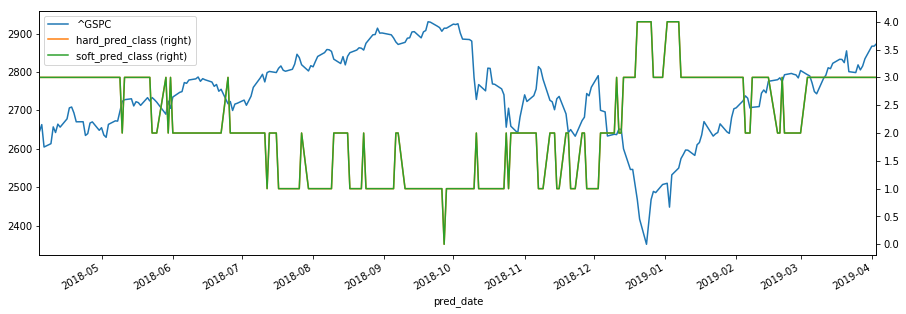

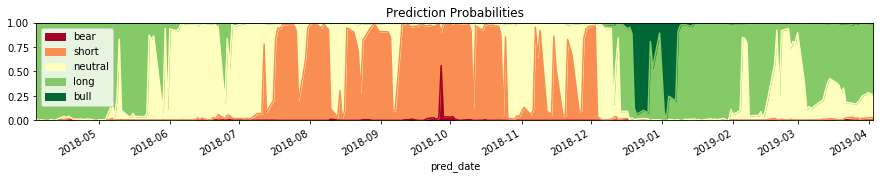

In [80]:
pre_class_cols = filter_cols(pred_df.columns, "pred_class")
pred_df.loc[:,[bench] + pre_class_cols].plot(
    secondary_y=pre_class_cols, figsize=(15, 5));
pred_df[fwd_ret_labels].plot.area(
        title='Prediction Probabilities',
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn');
f'Confidence Mean: {pred_df["soft_confidence"].mean().round(3)}, Median {pred_df["soft_confidence"].median().round(3)}'

### Step by step

#### Dataset creation

In [ ]:
# average the return of the next periods
# select only rows where Y variable is not null
train_idx = px_close.dropna(subset=[bench]).index
Y = px_fwd_rets(px_close.loc[train_idx, bench], bench, pred_fwd_windows).mean(axis=1)
Y.plot.hist(bins=50, title='Distribution of Forwards Returns')
Y.shape

In [ ]:
%%time
df_large = pd.DataFrame()

# rate transforms
rate_ft_df = rate_feats(px_close[rateSL], rate_windows)
df_large[rate_ft_df.columns] = rate_ft_df

# price momentum transforms
super_list = []
for ticker in include:
    inv = ticker in invert
    incl_px = True if ticker in incl_price else False
    df = px_close[ticker]
    ft_df = px_mom_feats(df, ticker, stds, inv, incl_px, sec_windows)
    super_list.append(ft_df.drop_duplicates())
df_large = pd.concat(super_list, axis=1).sort_index()

df_large[y_col] = Y

# drop NAs before discretizing
df_large = df_large.loc[train_idx, :]

print(df_large.shape)

In [ ]:
os.makedirs('tmp', exist_ok=True)
df_large.to_parquet('tmp/macro-ds-large')

#### Pre-processing

In [ ]:
df_large = pd.read_parquet('tmp/macro-ds-large')
df_large.shape

In [ ]:
# Trims dataset in case it's too large for experimentation
# Reduce dataset for experimentation
# Note that experiment dataset is not stratified
_, df_raw = train_test_split(df_large, test_size=100e-2, shuffle=False, )
df_raw.shape

In [ ]:
# keeps a chunk of the pre-processed dataset for predictions later
# take everything but Y var
look_back = 252*3
recent_X = df_large.iloc[-look_back:,:-1].copy()
print(recent_X.shape)

In [ ]:
# discretize returns into classes
df_raw.dropna(subset=[y_col], inplace=True)
df_raw.loc[:, y_col] = discret_rets(df_raw[y_col], cut_range, fwd_ret_labels)

y_col_dist = sample_wgts(df_raw[y_col], fwd_ret_labels)
(y_col_dist[fwd_ret_labels]).round(3)

In [ ]:
# how many empty values?
# (df_raw.isna().sum() / df_raw.count()).sort_values(ascending=False)

In [ ]:
df_raw.fillna(method='ffill', inplace=True)

In [ ]:
# Mean based imputer
imputer_on, scaler_on = True, True
imputer = SimpleImputer(missing_values=np.nan, strategy='median', copy=False)
scaler = StandardScaler()

df_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

pre_ml_df = df_raw.copy()
pre_ml_df.dropna(subset=[y_col], inplace=True)
pre_ml_df.loc[:, y_col] = pre_ml_df[y_col].astype(str)

X_cols = excl(pre_ml_df.columns, [y_col])

if imputer_on: pre_ml_df.loc[:, X_cols] = imputer.fit_transform(pre_ml_df[X_cols])
else: pre_ml_df.dropna(inplace=True)
if scaler_on: pre_ml_df.loc[:, X_cols] = scaler.fit_transform(pre_ml_df[X_cols])

X, y = pre_ml_df.drop(columns=y_col), pre_ml_df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

#### Train models

In [ ]:
# RandomForestClassifier
# best params from GridSearch
rfc_params = {
    'max_features': 40, 'n_estimators': 100, 'random_state': 7}

clf1 = RandomForestClassifier(**rfc_params, warm_start=True)

clf1.fit(X_train, y_train)
scores = clf1.score(X_train, y_train), clf1.score(X_test, y_test)
scores

In [ ]:
# MLPClassifier
# best params from GridSearch
mlp_params = {
    'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 65, 
    'learning_rate': 'adaptive', 'max_iter': 200, 
    'random_state': 3, 'solver': 'lbfgs'}

clf2 = MLPClassifier(**mlp_params, warm_start=True)

clf2.fit(X_train, y_train)
scores = clf2.score(X_train, y_train), clf2.score(X_test, y_test)
scores

In [ ]:
# ExtraTreesClassifier
clf3 = ExtraTreesClassifier(
    n_estimators=100, max_depth=None, 
    min_samples_split=2, random_state=0, warm_start=True)

clf3.fit(X_train, y_train)
scores = clf3.score(X_train, y_train), clf3.score(X_test, y_test)
scores

In [ ]:
%%time

eclf = VotingClassifier(
    estimators=[('rf', clf1), ('mlp', clf2), ('et', clf3)], 
    voting=vote)

clf = eclf.fit(X_train, y_train)
scores = clf.score(X_train, y_train), clf.score(X_test, y_test)

print(scores)

In [ ]:
os.makedirs(ml_path, exist_ok=True)
fname = ml_path + f'macro_ML_{vote}.pkl'
joblib.dump(clf, fname)
f'Saved {fname}'    

In [ ]:
clf = joblib.load(fname)
print('Loaded', fname)

In [ ]:
# predict historically including recent dates
if imputer_on: recent_X.loc[:, X_cols] = imputer.fit_transform(recent_X[X_cols])
else: recent_X.dropna(inplace=True)
if scaler_on: recent_X.loc[:, X_cols] = scaler.fit_transform(recent_X[X_cols])

In [ ]:
assert recent_X.shape[1] == X_train.shape[1]

In [ ]:
assert recent_X.shape[1] == X_train.shape[1]
preds = clf.predict(recent_X)
assert recent_X.shape[0] == preds.shape[0]

pred_class = np.array([fwd_ret_labels.index(x) for x in preds])

SPY = px_close.loc[recent_X.index, bench].to_frame()
SPY['pred_class'] = pred_class
SPY['pred_label'] = preds

if vote == 'soft':
    probs = clf.predict_proba(recent_X)
    pred_prob = np.argmax(probs, axis=1)
    SPY.loc[:, 'high_prob'] = [x[np.argmax(x)] for x in probs] # higest prob
    SPY.loc[:, 'pred_prob'] = probs[range(pred_class.shape[0]), pred_class] # predict class prob

SPY.dropna(subset=[bench], inplace=True)    

In [ ]:
# why are predict classes and prob distribution do not math?
# preds, pred_class, probs[-10:]
# df = pd.DataFrame()
# df['pred_class'] = pred_class
# df['pred_prob'] = probs[range(pred_class.shape[0]), pred_class]
# df.plot(secondary_y='pred_prob')

In [ ]:
# plot predictions
SPY['pred_class'] = pred_class
SPY['pred_label'] = preds
SPY.loc[:,[bench, 'pred_class']].plot(secondary_y='pred_class', figsize=(15, 5));

if vote == 'soft':
    SPY[['high_prob']].plot(
        title='Historical predictions',
        figsize=(15, 2), ylim=(0, 1),);
    SPY[['pred_prob']].plot(
        title='Probability of highest & predicted class',
        figsize=(15, 2), ylim=(0, 1),);
    
    prob_df = pd.DataFrame(probs, columns=fwd_ret_labels, index=recent_X.index)
    prob_df.plot(
        title='Class probabilities',
        figsize=(15, 8), subplots=True, ylim=(0,1));    

In [ ]:
if vote == 'soft':
    SPY[['high_prob', 'pred_prob']].plot.hist(
        bins=50, xlim=(0,1), title='Confidence Distribution')
    print('Probability for predicted class: Mean %.f, median %.f, ' % (
        SPY.pred_prob.mean() * 100,
        SPY.pred_prob.median() * 100))
    print('Probability for highest class: Mean %.f, median %.f, ' % (
        SPY.high_prob.mean() * 100,
        SPY.high_prob.median() * 100))

In [ ]:
SPY.tail(10)

#### Metrics

In [ ]:
draw_tree(clf1.estimators_[0], X, precision=3)

In [ ]:
show_fi(clf1, X, 25)

In [ ]:
log_loss(y_test, clf1.predict_proba(X_test))

In [ ]:
print('Confussion Matrix\n', confusion_matrix(clf.predict(X_test), y_test, labels=fwd_ret_labels))

In [ ]:
print('Classificaton report\n', classification_report(clf.predict(X_test), y_test, target_names=fwd_ret_labels))

In [ ]:
fi = rf_feat_importance(clf1, pd.DataFrame(X)); fi[:10]

In [ ]:
clf1.predict_proba(X_test)

In [ ]:
[plt.plot(x.tolist(), alpha=0.1, color='b', marker='*', linewidth=0) for x in clf1.predict_proba(X_test)];

#### Gridsearches

In [ ]:
%%time
# GridSearchCV for RandomForestClassifier
verbose = True
parameters = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'random_state': np.arange(0, 5, 1),}
clf = GridSearchCV(RandomForestClassifier(), 
                   parameters, n_jobs=-1, 
                   cv=5, iid=True, verbose=5)
clf.fit(X_train, y_train)
if verbose: print_cv_results(
    clf, X_train, X_test, y_train, y_test, 
    feat_imp=True, top=20)

In [ ]:
%%time
# GridSearchCV for MLPClassifier
parameters = {
    'solver': ['lbfgs'], # ['lbfgs', 'sgd', 'adam']
    'max_iter': [200], # [200, 400, 600]
    'activation': ['relu'], # ['logistic', 'tanh', 'relu']
    'alpha': 10.0 ** -np.arange(2, 5, 1), # 10.0 ** -np.arange(2, 5, 1)
    'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
    'hidden_layer_sizes': np.arange(5, X_train.shape[1] // 3, int(X_train.shape[1] * 0.1)), # np.arange(5, 50, 10)
    'random_state': np.arange(0, 5, 1)} # np.arange(0, 10, 2)
clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=5,
                  iid=True, verbose=5)
clf.fit(X_train, y_train)
if verbose: print_grid_search(
    clf, X_train, y_train, X_test, y_test, 
    feat_imp=False, top=20)

### Old

#### Feature construction

In [ ]:
# FX
FX = ['EURUSD=X', 'JPY=X', 'GBPUSD=X', 'CNY=X', 'CHF=X', 'DX-Y.NYB']
invert = ['EURUSD=X', 'GBPUSD=X']
df_raw = px_close[FX]
df_raw.describe().T

In [ ]:
fx_df = df_raw.copy()
fx_df[invert] = (1 / df_raw[invert])
fx_df.tail(252)
fx_chg_df = fx_df.pct_change().rolling(60).sum()
fx_chg_df.plot.kde()

In [ ]:
rates = px_close[rateSL]
rates.plot.kde(alpha=1, title='Yield Curve Rate Distribution')
rate_feats(rates, [60]).plot.kde(title='10Yr - 3M Spread')

In [ ]:
%%time
# Uses px_mom_feats for FX transforms
FX = ['EURUSD=X', 'JPY=X', 'GBPUSD=X', 'CNY=X', 'CHF=X', 'DX-Y.NYB']
invert = ['EURUSD=X', 'GBPUSD=X']

ndf = pd.DataFrame() 
for fx in FX:
    inv = True if fx in invert else False
    df = get_symbol_pricing(fx)
    ft_df = px_mom_feats(df, fx, 1, inv, True)
    ndf[ft_df.columns] = ft_df
ndf.plot.hist(alpha=0.5, legend=False)

In [ ]:
ft_df = px_mom_feats(get_symbol_pricing('^VIX'), '^VIX', 2, False, True, [20])
print(ft_df.columns)
ft_df.iloc[:,:].plot.hist()

In [ ]:
symbol = '^GSPC'
px_df = get_symbol_pricing(symbol)

ft_df = px_mom_feats(px_df, symbol)
# ft_df.plot(subplots=True, figsize=(10,15));
ft_df.plot.hist(alpha=0.5);

In [ ]:
ft_df = px_fwd_rets(px_df, symbol)
ft_df.plot.hist(alpha=0.5);
ft_df[symbol] = px_df['close']
ft_df.tail(252*4).plot(secondary_y=symbol, figsize=(10,5));

In [ ]:
%%time
# average different time frames of fwd rets for all benchmarks
# do we try to estimate the average of all benchmarks or just one?
# do we try to estimate three type of fwd rets [20, 60, 120] or just one?

# calculate forward returns for all bechmarks
fwd_rets_df = pd.DataFrame()
for s in benchSL:
    px_df = get_symbol_pricing(s)
    fwd_ret = px_fwd_rets(px_df, s)
    fwd_rets_df[fwd_ret.columns] = fwd_ret
fwd_rets_df.tail()

[fwd_rets_df[[x for x in fwd_rets_df.columns if y in x]].mean(axis=1).plot.hist(alpha=0.5)
     for y in ['g20', 'g60', 'g120']]

#### Visualizations

In [ ]:
locs = [-int(x**3) for x in range(1, 7, 1)]
px_close[rateSL].iloc[locs, :].T.plot(title='Historical Yield Curve');
#f'Yield curve for the last {locs} days'

In [ ]:
# show correlations with Y variables
show = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
ml_ds_df.corr()[show]

In [ ]:
# series distributions
%time ml_ds_df.hist(figsize=(15,15));

In [ ]:
# scatter plots
%time pd.plotting.scatter_matrix(ml_ds_df, alpha=0.1, figsize=(40, 40));

In [ ]:
# historical returns for 1, 3, and 6 months
secpx['mktHistPctChgStds'] = SPY_pct_chg.apply(sign_compare, args=(SPY_pct_chg.std(),))
secpx['mktHistPctChg1m'] = SPY_close.pct_change(periods=20)
secpx['mktHistPctChg3m'] = SPY_close.pct_change(periods=60)
secpx['mktHistPctChg6m'] = SPY_close.pct_change(periods=120)
secpx['mktPerc52WkHigh'] = (SPY_close / SPY_close.rolling(252).max())
secpx['mktPerc52WkLow'] = (SPY_close / SPY_close.rolling(252).min())

show = ['mktHistPctChgStds', 'mktHistPctChg1m', 'mktHistPctChg3m', 
        'mktHistPctChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot(secondary_y='mktHistPctChgStds');
show = ['mktPerc52WkLow']
secpx[show].tail(252*4).plot();

In [ ]:
# Forward returns, 1w, 1m, 3m
SPY_close.pct_change(5).shift(-5)
secpx['mktFwdChg1m'] = SPY_close.pct_change(20).shift(-20)
secpx['mktFwdChg3m'] = SPY_close.pct_change(60).shift(-60)
secpx['mktFwdChg6m'] = SPY_close.pct_change(120).shift(-120)

show = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot();

In [ ]:
show = [bench_symbol, 'mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx[show].tail(252*4).plot(secondary_y=bench_symbol, figsize=(12,5));

In [ ]:
# cumulative deltas and gap analysis
secpx['pctChgStds'] = pct_chg.apply(sign_compare, args=(pct_chg.std(),))
secpx['openGap1m'] = (openpx - closepx.shift(1)).rolling(20).sum()
secpx['hlDelta1m'] = (highpx - lowpx).rolling(20).sum()
secpx['cumChg1m'] = (closepx - closepx.shift(1)).rolling(20).sum()
secpx['cumChg3m'] = (closepx - closepx.shift(1)).rolling(60).sum()
secpx['cumChg6m'] = (closepx - closepx.shift(1)).rolling(120).sum()
secpx['perc52WkLow'] = (closepx / closepx.rolling(252).min())

show = ['pctChgStds', 'openGap1m', 'hlDelta1m', 
        'cumChg1m', 'cumChg3m', 'cumChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot(secondary_y='pctChgStds');
show = ['perc52WkLow']
secpx[show].tail(252*4).plot();

In [ ]:
show = ['pctChgStds', 'mktHistPctChgStds']
secpx[show].hist();
secpx[show].tail(252*4).plot();

In [ ]:
# rolling SPY correlations
secpx['crossCorr1m'] = closepx.pct_change().rolling(20).corr(SPY_pct_chg)
secpx['crossCorr3m'] = closepx.pct_change().rolling(60).corr(SPY_pct_chg)

show = [bench_symbol, 'crossCorr1m', 'crossCorr3m']
secpx[show].tail(252*4).plot(secondary_y=bench_symbol);
# closepx.pct_change().corr(SPY_pct_chg)

#### Missing values

In [ ]:
# px_close.loc[pred_X.index, keep_bench].tail(20)
# pred_X.tail()

In [ ]:
# pred_X.fillna(method='ffill', inplace=True)
# na = pred_X.tail(120).isna().any(0)
# pred_X[na[na.values].index]

#### Fixing timeseries concatenation

In [ ]:
super_list = []
for n, t in enumerate(keep_sect):
    try:
        df = get_symbol_pricing(t, freq, cols=None)
        rename_col(df, 'close', t)
        print("Retrieving pricing: {0}, {1}".format(t, df.shape))
        df.index = df.index.strftime('%Y-%m-%d')
        super_list.append(df[t])
    except Exception as e:
        print("Exception, get_mults_pricing: {0}\n{1}".format(t, e))

In [ ]:
full_df = pd.DataFrame(super_list[0])
if len(super_list[1:]):
    for x in super_list[1:]: full_df = pd.merge(full_df, x, left_index=True, right_index=True, how='outer')
full_df.index = pd.to_datetime(full_df.index)

In [ ]:
full_df.tail(20)

In [ ]:
super_list[0].tail(10)

In [ ]:
super_list[1].tail(10)

In [ ]:
super_list[2].tail(10)

In [ ]:
get_symbol_pricing('JPY=X')

In [ ]:
full_df.tail(30).sort_index()

In [ ]:
for d in super_list:
    print(d.shape, d.drop_duplicates().shape)

In [ ]:
super_list[1].duplicated().sort_values()

In [ ]:
df = pd.concat(super_list, axis=1)

In [ ]:
super_list[0].tail(10).index, \
super_list[1].tail(10).index, \
super_list[2].tail(10).index, \
super_list[3].tail(10).index

In [ ]:
ss = get_symbol_pricing('DX-Y.NYB', freq).tail(20)

In [ ]:
ss.index.strftime('%Y-%m-%d')

In [ ]:
# pd.merge(super_list[1], super_list[2], left_index=True, right_index=True)
# pd.concat(super_list, axis=1)
init_df = pd.DataFrame(super_list[0])
for x in super_list[1:]:
    init_df = pd.merge(init_df, x, left_index=True, right_index=True)
init_df.tail(60)

In [ ]:
pd.concat(super_list, axis=1, ).tail(15)

In [ ]:
for d in super_list: d.drop_duplicates(inplace=True)

In [ ]:
df = pd.concat(super_list, axis=1, copy=False)